<a href="https://colab.research.google.com/github/mohammedterry/NLP_for_ML/blob/master/Sentence_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
example_sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
    
    # Cats and Dogs
    "Cats chase dogs",
    "Dogs chase cats",
]

In [0]:
def most_similar(vector, other_vectors):
  from scipy.spatial.distance import cosine

  scores = [cosine(vector, vec) for vec in other_vectors]
  ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)])
  ranked_candidates = [example_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
  return ranked_candidates

In [0]:
def plot_sentences(sentences, svectors):
  %matplotlib inline
  from sklearn.decomposition import PCA
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(svectors)

  import pandas as pd
  dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y'])
    
  import seaborn as sns    
  graph=sns.regplot(data=dataframe, x="x", y="y", fit_reg=False, marker="+")
  [graph.text(x, y, s) for x,y,s in zip(dataframe['x'],dataframe['y'],sentences)]

# Char2Vec

* Idea:  Convert the sentence (string of characters) into a fixed-size vector (150 dimensions) according to the sequence of characters in its string (takes character order into account).
* Pros:  Relatively Simple
* Cons:  Sentences spellt similarly but with different meanings end up having similar vectors (e.g. "I like my phone" & "I don't like my phone")

In [4]:
!pip3 install chars2vec
import chars2vec
c2v_model = chars2vec.load_model('eng_150')

    100% |████████████████████████████████| 1.9MB 2.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/60/6d/1aa6b4d074db318663a018ce60980e8856242ab28d01b45ea8
Successfully built chars2vec


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def char2vec(sentences):
  return c2v_model.vectorize_words(sentences)

In [0]:
c2v_vectors = char2vec(example_sentences)

In [0]:
most_similar(char2vec(["i like my cell phone"]), c2v_vectors)

['My phone is not good.', 'Global warming is real', 'I like my phone']

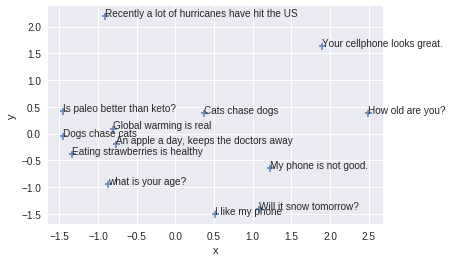

In [0]:
plot_sentences(example_sentences, c2v_vectors)

# Spacy
* Idea: Use spacy's inbuilt method for forming sentence vectors
* Pros: Simple


In [12]:
import spacy
!python3 -m spacy download en_core_web_lg
sp = spacy.load('en_core_web_lg') 

    100% |████████████████████████████████| 852.3MB 63.6MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [13]:
spacy_sentences = [sp(sentence) for sentence in example_sentences]

scores = [sp("i like my cell phone").similarity(sp_sent) for sp_sent in spacy_sentences]
ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)], reverse = True)
ranked_candidates = [example_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
ranked_candidates

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

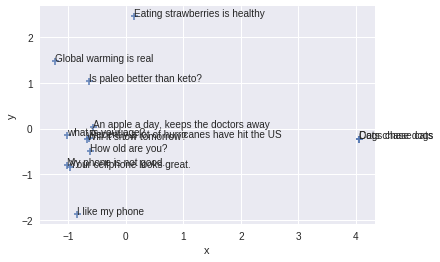

In [0]:
plot_sentences(example_sentences, [spacy_sentence.vector for spacy_sentence in spacy_sentences])

# Universal Encoder
* Idea: Sentence in -> Fixed-size Vector out (520 dimensions)
* Pros: Regardless of the number of words in the sentence, a single vector is given back
* Cons:  Compute Intensive

In [7]:
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

W0309 07:29:47.415988 140293466404736 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
def universal_sentence(sentences):
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    vectors = session.run(embed(sentences))
    return vectors

In [0]:
uni_vectors = universal_sentence(example_sentences)

In [0]:
most_similar(universal_sentence(["i like my cell phone"]), uni_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

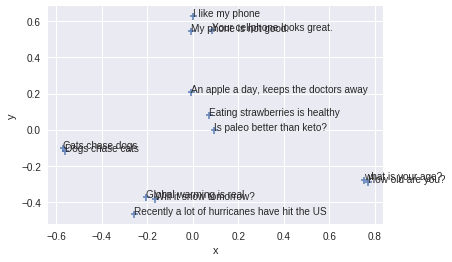

In [0]:
plot_sentences(example_sentences, uni_vectors)

# BERT as a Sentence Vector

For classification tasks, the first vector (corresponding to [CLS]) is used as as the "sentence vector". Note that this only makes sense because the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]

In [39]:
!pip3 install pytorch_pretrained_bert

from pytorch_pretrained_bert import BertTokenizer
tokeniser = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)

from pytorch_pretrained_bert import BertModel
bert = BertModel.from_pretrained('bert-large-uncased')

import torch

    100% |████████████████████████████████| 122kB 6.3MB/s 
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


100%|██████████| 1248501532/1248501532 [00:37<00:00, 31950299.31B/s]


In [0]:
def sentence_bert(sentence, model):
  tokenised_sentence = ["[CLS]"] + tokeniser.tokenize(sentence) +  ["[SEP]"]
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  encoded_layers, _ = model(tokens_tensor, segments_tensor)
  sent_vector = encoded_layers[0][-1][0]
  return sent_vector.detach().numpy()

In [0]:
bert_vectors = [sentence_bert(sentence, bert) for sentence in example_sentences]

In [0]:
most_similar(sentence_bert("i like my cell phone", bert), bert_vectors)

['I like my phone', 'what is your age?', 'How old are you?']

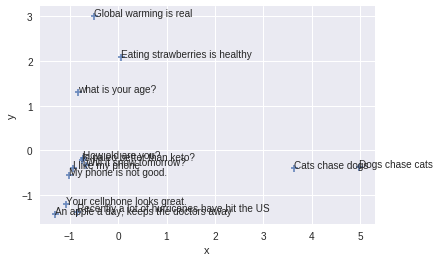

In [0]:
plot_sentences(example_sentences, bert_vectors)

# Combination (Char2Vec + Universal Encoder + BERT)

In [0]:
import numpy as np

def combine(vectors):
  return np.concatenate(vectors)

In [0]:
combo_vectors = [combine([a,b,c]) for a,b,c in zip(c2v_vectors, uni_vectors, bert_vectors)]

In [44]:
test_sentence = "i like my cell phone"
most_similar(combine([char2vec([test_sentence])[0],universal_sentence([test_sentence])[0], sentence_bert(test_sentence, bert)]), combo_vectors)

['I like my phone', 'My phone is not good.', 'what is your age?']

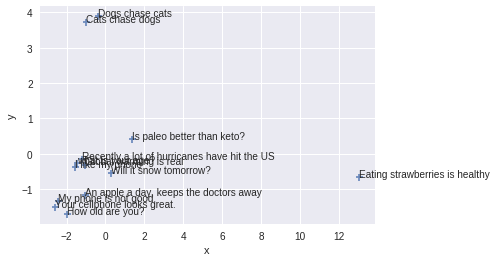

In [45]:
plot_sentences(example_sentences, combo_vectors)

# Average of Word Vectors

In [0]:
import numpy as np

def mean_vectors(vectors, weights = None):
  return np.average(vectors, axis=0, weights = weights)

# (Tf-Idf) Weighted Average of Word Vectors

In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
    
tfidf = TfidfVectorizer()
importance = tfidf.fit_transform(example_sentences) 
feature_names = tfidf.get_feature_names()
tfs = {feature_names[col] : importance[0, col]  for col in importance.nonzero()[1]}

def tfidf_weights(tokens, weights):
  ws = [0.0001 for _ in range(len(tokens))]
  for i,token in enumerate(tokens):
    if token in weights:
      w = weights[token]
      if w > 0:
        ws[i] = w
  return ws

In [0]:
from gensim.utils import tokenize

test_sentence = "i like my cell phone"
example_tokens = [token for token in tokenize(test_sentence)]
example_weights = tfidf_weights(example_tokens, tfs)
print(example_weights)
' '.join([example_token.upper()  if tfidf_weight > .5 else example_token for example_token,tfidf_weight in zip(example_tokens,example_weights)])

[0.0001, 0.6340628633768814, 0.5467925956367323, 0.0001, 0.5467925956367323]


'i LIKE MY cell PHONE'

## BERT

In [0]:
def convert_to_bert(sentence, model):
  tokenised_sentence = tokeniser.tokenize(sentence)
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  encoded_layers, _ = model(tokens_tensor, segments_tensor)
  bert_vectors = encoded_layers[0][-1]
  return bert_vectors.detach().numpy()

In [0]:
mean_bert_vectors = [mean_vectors(convert_to_bert(sentence, bert)) for sentence in example_sentences]
w_mean_bert_vectors = [mean_vectors(convert_to_bert(sentence, bert), tfidf_weights(tokeniser.tokenize(sentence), tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_bert(test_sentence, bert)), mean_bert_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

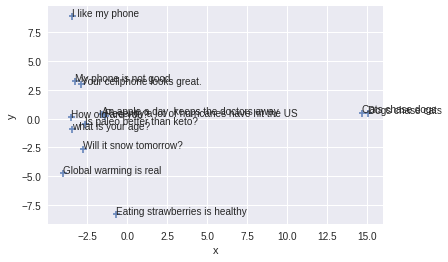

In [0]:
plot_sentences(example_sentences, mean_bert_vectors)

In [0]:
most_similar(mean_vectors(convert_to_bert(test_sentence, bert), tfidf_weights(tokeniser.tokenize(test_sentence), tfs)), w_mean_bert_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

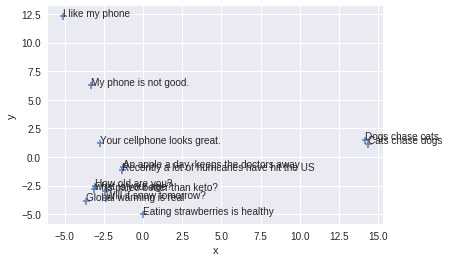

In [0]:
plot_sentences(example_sentences, w_mean_bert_vectors)

## ELMO

In [0]:
!pip3 install allennlp
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()

    100% |████████████████████████████████| 5.6MB 5.6MB/s 
    100% |████████████████████████████████| 512kB 22.5MB/s 
    100% |████████████████████████████████| 51kB 19.9MB/s 
    100% |████████████████████████████████| 552kB 22.9MB/s 
    100% |████████████████████████████████| 245kB 27.2MB/s 
    100% |████████████████████████████████| 12.6MB 2.9MB/s 
    100% |████████████████████████████████| 133kB 32.9MB/s 
    100% |████████████████████████████████| 1.5MB 14.2MB/s 
    100% |████████████████████████████████| 4.5MB 6.7MB/s 
    100% |████████████████████████████████| 51kB 18.9MB/s 
    100% |████████████████████████████████| 143kB 30.8MB/s 
    100% |████████████████████████████████| 2.3MB 11.4MB/s 
    100% |████████████████████████████████| 51kB 19.1MB/s 
    100% |████████████████████████████████| 61kB 17.9MB/s 
    100% |████████████████████████████████| 51kB 18.4MB/s 
    100% |████████████████████████████████| 7.5MB 5.1MB/s 
    100% |████████████████████████████████| 92kB

100%|██████████| 374434792/374434792 [00:13<00:00, 27453086.02B/s]


In [0]:
def convert_to_elmo(sentence, model):
  return elmo.embed_sentence(sentence.split())[-1]

In [0]:
mean_elmo_vectors = [mean_vectors(convert_to_elmo(sentence, elmo)) for sentence in example_sentences]
w_mean_elmo_vectors = [mean_vectors(convert_to_elmo(sentence, elmo), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_elmo(test_sentence, elmo)), mean_elmo_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

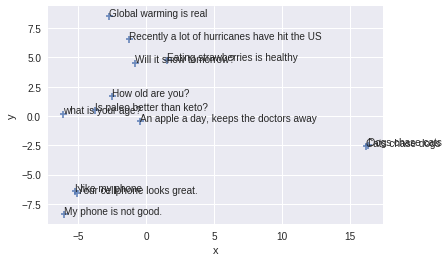

In [0]:
plot_sentences(example_sentences, mean_elmo_vectors)

In [0]:
most_similar(mean_vectors(convert_to_elmo(test_sentence, elmo), example_weights), w_mean_elmo_vectors)

['I like my phone', 'Your cellphone looks great.', 'what is your age?']

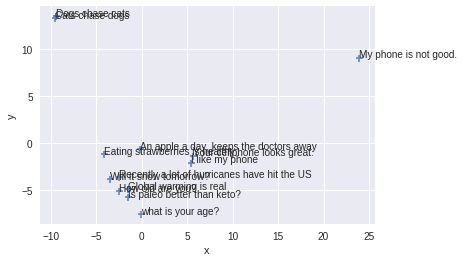

In [0]:
plot_sentences(example_sentences, w_mean_elmo_vectors)

## FastText & GloVe

In [0]:
!pip3 install mxnet
!pip3 install gluonnlp

import gluonnlp
fasttext = gluonnlp.embedding.create('fasttext', source='wiki.simple')
glove = gluonnlp.embedding.create('glove', source='glove.6B.300d') 

    100% |████████████████████████████████| 28.4MB 651kB/s 
    100% |████████████████████████████████| 61kB 6.2MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


    100% |████████████████████████████████| 194kB 6.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/19/c4/f4/70dc14c8b01db12cd4f88c6f71128bb88de545a7690e192ce0
Successfully built gluonnlp
Embedding file wiki.simple.npz is not found. Downloading from Gluon Repository. This may take some time.
Embedding file glove.6B.300d.npz is not found. Downloading from Gluon Repository. This may take some time.


In [0]:
def convert_to_ft_glove(sentence,model):
  return [model[word].asnumpy() for word in sentence.split()]

In [0]:
mean_fasttext_vectors = [mean_vectors(convert_to_ft_glove(sentence, fasttext)) for sentence in example_sentences]
w_mean_fasttext_vectors = [mean_vectors(convert_to_ft_glove(sentence, fasttext), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

mean_glove_vectors = [mean_vectors(convert_to_ft_glove(sentence, glove)) for sentence in example_sentences]
w_mean_glove_vectors = [mean_vectors(convert_to_ft_glove(sentence, glove), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, fasttext)), mean_fasttext_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

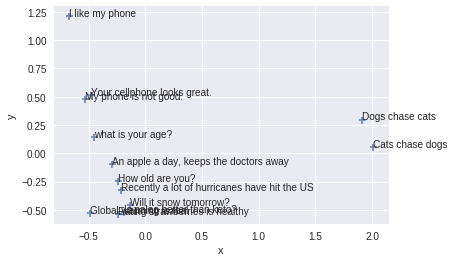

In [0]:
plot_sentences(example_sentences, mean_fasttext_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, fasttext),example_weights), w_mean_fasttext_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

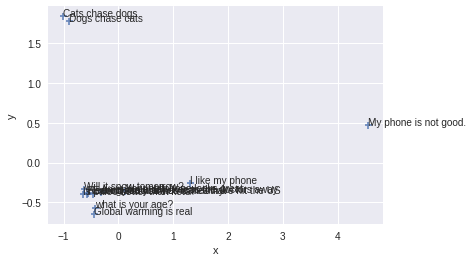

In [0]:
plot_sentences(example_sentences, w_mean_fasttext_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, glove)), mean_glove_vectors)

['I like my phone', 'My phone is not good.', 'what is your age?']

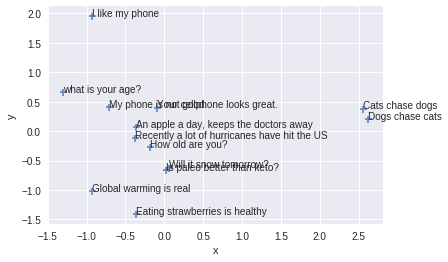

In [0]:
plot_sentences(example_sentences, mean_glove_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, glove), example_weights), w_mean_glove_vectors)

['I like my phone', 'what is your age?', 'My phone is not good.']

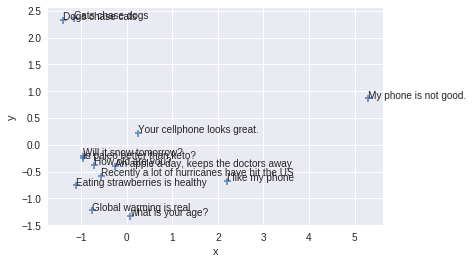

In [0]:
plot_sentences(example_sentences, w_mean_glove_vectors)

## NumberBatch

In [0]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-17.06.txt.gz
!gunzip numberbatch-17.06.txt.gz

--2019-03-08 20:16:28--  https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-17.06.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.216.101.251
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.216.101.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1193268949 (1.1G) [text/plain]
Saving to: ‘numberbatch-17.06.txt.gz’

numberbatch-17.06.t 100%[===================>]   1.11G  56.4MB/s    in 21s     

2019-03-08 20:16:49 (53.9 MB/s) - ‘numberbatch-17.06.txt.gz’ saved [1193268949/1193268949]



In [0]:
from gensim.models.keyedvectors import KeyedVectors
numberbatch = KeyedVectors.load_word2vec_format("numberbatch-17.06.txt", binary=False)

In [0]:
from gensim.utils import tokenize

def convert_to_numberbatch(sentence, language = "en"):
  tokens = [token.lower().replace(' ','_') for token in tokenize(sentence)]
  return [numberbatch[f"/c/{language}/{token}"] for token in tokens]

In [0]:
mean_numberbatch_vectors = [mean_vectors(convert_to_numberbatch(sentence)) for sentence in example_sentences]
w_mean_numberbatch_vectors = [mean_vectors(convert_to_numberbatch(sentence), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_numberbatch(test_sentence)), mean_numberbatch_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

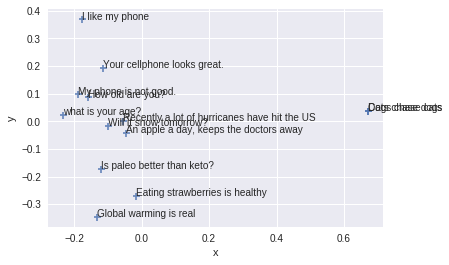

In [0]:
plot_sentences(example_sentences, mean_numberbatch_vectors)

In [0]:
most_similar(mean_vectors(convert_to_numberbatch(test_sentence), example_weights), w_mean_numberbatch_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

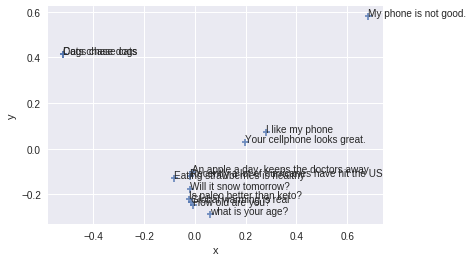

In [0]:
plot_sentences(example_sentences, w_mean_numberbatch_vectors)

# CNN combined Word Vectors

# Random Projection Word Vectors

# Stacked Autoencoders

# Triplets of Sentence Vectors (Semantic Net Vectors)
Allen NLP's Open Information Extraction to identify triplet.  Then embed

# Benchmarking

https://github.com/facebookresearch/SentEval